In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse
import matplotlib as mpl

In [12]:
experiment = pd.DataFrame({
    "Trial": [1, 51, 101, 151, 201],
    "TrialEnd": np.array([51, 101, 151, 201, 251]) - 1,
    "Type": ["Normal", "Trajectory", "EndPos", "RL", "NormalSudden"]
})

n_attempts = 250

attempts = list(range(1, n_attempts + 1))

types = []
for i in range(len(experiment)):
    start = experiment["Trial"][i]
    end = experiment["Trial"][i + 1] if i + 1 < len(experiment) else n_attempts + 1
    types.extend([experiment["Type"][i]] * (end - start))

full_experiment = pd.DataFrame({ "Trial": attempts, "Type": types })

In [26]:
subject1 = pd.read_csv("Subject_1.csv")
subject1 = pd.merge(subject1, full_experiment, on = "Trial")

subject2 = pd.read_csv("Subject_2.csv")
subject2 = pd.merge(subject2, full_experiment, on = "Trial")

subject1

,Trial,Score,TotalScore,FeedbackType,EndPosX,EndPosY,Perturbation,PerturbationForce,Type
0,1,0,0,NaN,609.411889,671.907251,NaN,0.0,Normal
1,2,-35,-35,NaN,509.969133,298.938267,NaN,0.0,Normal
2,3,90,55,NaN,251.859997,211.936223,NaN,0.0,Normal
3,4,0,55,NaN,426.955589,610.296324,NaN,0.0,Normal
4,5,88,143,NaN,261.778802,287.938267,NaN,0.0,Normal
...,...,...,...,...,...,...,...,...,...
245,246,0,4286,NaN,194.901063,393.364691,NaN,0.0,NormalSudden
246,247,-50,4236,NaN,-84.096011,136.622296,NaN,0.0,NormalSudden
247,248,0,4236,NaN,219.971053,344.464050,NaN,0.0,NormalSudden
248,249,-23,4213,NaN,308.450045,326.971053,NaN,0.0,NormalSudden


In [27]:
screen_width, screen_height = 1680, 1050
table_width = screen_width - 100
table_height = int(screen_height * 0.9)

zone_width = int(table_width * 0.95)
zone_height = 150

scoring_rect = {
    "x": (screen_width - zone_width) // 2,
    "y": int(table_height * 0.2),
    "width": zone_width,
    "height": zone_height
}

# Calculate the corner properties
scoring_rect["topleft"] = (scoring_rect["x"], scoring_rect["y"])
scoring_rect["topright"] = (scoring_rect["x"] + scoring_rect["width"], scoring_rect["y"])
scoring_rect["bottomleft"] = (scoring_rect["x"], scoring_rect["y"] + scoring_rect["height"])
scoring_rect["bottomright"] = (scoring_rect["x"] + scoring_rect["width"], scoring_rect["y"] + scoring_rect["height"])

green_triangle = [
    scoring_rect["topleft"],
    scoring_rect["topright"],
    scoring_rect["bottomleft"]
]

red_triangle = [
    scoring_rect["bottomright"],
    scoring_rect["bottomleft"],
    scoring_rect["topright"]
]

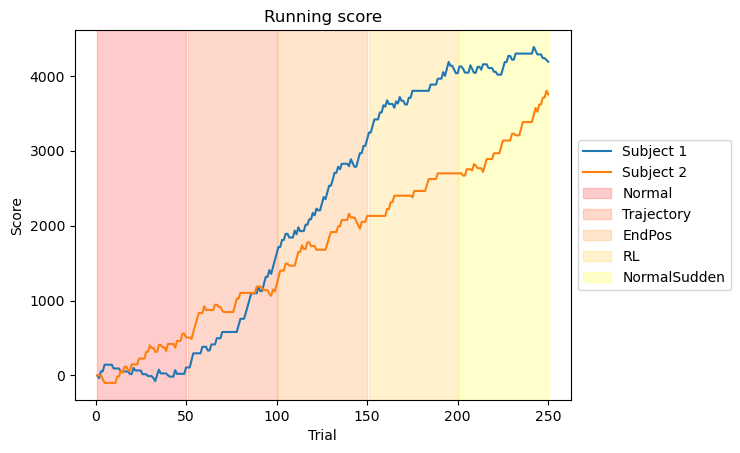

In [30]:
fig, axs = plt.subplots(nrows = 1, ncols = 1)

axs.plot(
    subject1.Trial,
    subject1.TotalScore,
    label = "Subject 1"
)

axs.plot(
    subject2.Trial,
    subject2.TotalScore,
    label = "Subject 2"
)

color_map = mpl.colormaps["autumn"]
n_colors = len(experiment.Type.unique())
colors = [color_map(idx / (n_colors - 1)) for idx in range(n_colors)]
colors = dict(zip(experiment.Type.unique(), colors))
unique_periods = experiment.Type.unique()

# Show the different experimental periods
for i, change in experiment.iterrows():
    label = change.Type if change.Type in unique_periods else ""
    unique_periods = unique_periods[unique_periods != change.Type]

    start = change.Trial
    end = change.TrialEnd

    axs.axvspan(
        start, end,
        alpha = 0.2,
        label = label,
        color = colors.get(change.Type)
    )

axs.legend(loc = "center left", bbox_to_anchor = (1, 0.5))

axs.set_xlabel("Trial")
axs.set_ylabel("Score")
plt.title("Running score")
plt.show()

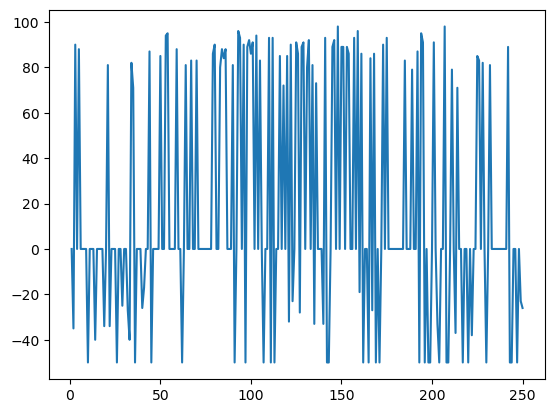

In [5]:
plt.plot(
    data.Trial,
    data.Score
)

plt.show()

In [6]:
def plot_ellipse_around_points(x, y, ax, color, nstd = 2, **kwargs):
    cov = np.cov(x, y)
    pos = (np.mean(x), np.mean(y))

    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * nstd * np.sqrt(eigvals)
    
    ellipse = Ellipse(xy = pos, width = width, height = height, angle = angle, **kwargs)
    
    ax.scatter(pos[0], pos[1], marker = "x", color = color)
    ax.add_patch(ellipse)

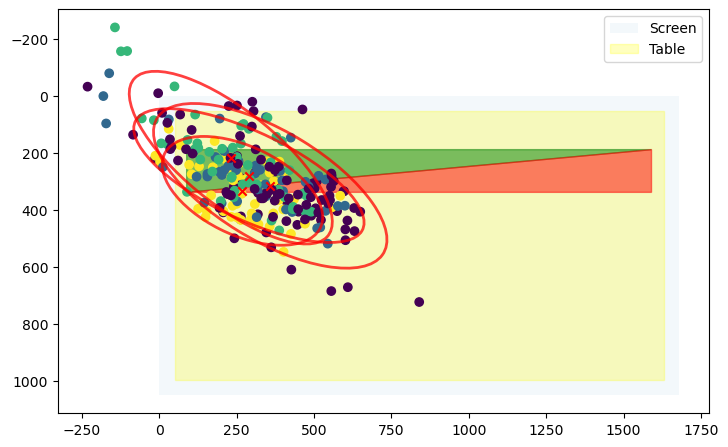

In [7]:
fig, ax = plt.subplots(figsize = (screen_width / 200, screen_height / 200))

screen = Rectangle((0, 0), screen_width, screen_height, alpha = 0.05, label = "Screen")
ax.add_patch(screen)

table = Rectangle(
    ((screen_width - table_width) // 2, (screen_height - table_height) // 2),
    table_width, table_height,
    alpha = 0.25,
    color = "yellow",
    label = "Table"
)
ax.add_patch(table)

green_x, green_y = zip(*green_triangle)
ax.fill(green_x, green_y, color = "green", alpha = 0.5)

red_x, red_y = zip(*red_triangle)
ax.fill(red_x, red_y, color = "red", alpha = 0.5)

ax.scatter(
    data.EndPosX,
    data.EndPosY,
    c = pd.Categorical(data.FeedbackType).codes
)

for feedback in data.FeedbackType.unique():
    group_data = data[data.FeedbackType == feedback]
    ellipse = plot_ellipse_around_points(
        group_data.EndPosX, group_data.EndPosY,
        ax = ax,
        color = "red",
        alpha = 0.75,
        edgecolor = "red",
        facecolor = "none",
        lw = 2
    )

plt.gca().invert_yaxis()
plt.legend()
plt.show()